In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
import os
%matplotlib inline

In [24]:
# For mask dataset

def get_ds(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32)
    img = tf.divide(tf.subtract(tf.multiply(img,255),127.5),127.5)
    return tf.image.resize(img,(64,64)) 

images = []
for i in os.scandir('storage/masks/'):
    images.append(i.path)

images = tf.data.Dataset.from_tensor_slices(images)
BATCH_SIZE = 16
train_images = images.map(get_ds,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE).shuffle(10000)

In [25]:
def make_generator_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(8*8*128,input_shape=(100,),use_bias=False))    # creates output shape of 7,7 with number of neurons - [7,7,256]
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8,8,128)))
    assert model.output_shape == (None, 8, 8, 128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(1,1),padding='same',use_bias=False))    # stride (1,1) keeps the same shape as that of input
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    ## output of shape (7,7,128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))     # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    ## output shape (14,14,64)

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))     # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh',use_bias=False))
    assert model.output_shape == (None, 64, 64, 3)
    ## output shape (28,28,1) the required shape
    
    return model


In [26]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)

In [27]:
def normalize(x):
    return 

In [28]:
# Numpy to convert to a range
image = np.float64(generated_image)
image = (255*(image - np.min(image))/np.ptp(image)).astype(int)

In [29]:
image = image[0, :, :, :]

In [30]:
image.max()

255

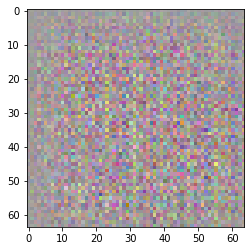

In [31]:
plt.imshow(image)

In [32]:
def make_discriminator_model():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [33]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00179959]], shape=(1, 1), dtype=float32)


In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [36]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [38]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [39]:
EPOCHS = 400
noise_dims = 100
num_egs_to_generate = 16
seed = tf.random.normal([num_egs_to_generate,noise_dims])

In [40]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dims])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = generator(noise,training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradients = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))

In [41]:
def generate_and_save_output(model,epoch,test_input):

  predictions = model(test_input,training=False)
  # predictions = predictions.numpy().reshape(16,64,64,1)
  fig = plt.figure(figsize=(4,4))
  # print(predictions)
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow((predictions[i]*127.5+127.5).numpy().astype(np.uint8),cmap='gray')
    plt.axis('off')
  plt.savefig(f'./results_gan2/image_at_epoch_{epoch}.png')
  plt.show()

In [42]:

from IPython import display
import time
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()
    for batch in dataset:
      train_step(batch)
    display.clear_output(wait=True)
    generate_and_save_output(generator,epoch+1,seed)

    if (epoch+1)%15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1}/{EPOCHS} is {time.time()-start}')
  
  display.clear_output(wait=True)
  generate_and_save_output(generator,epochs,seed)

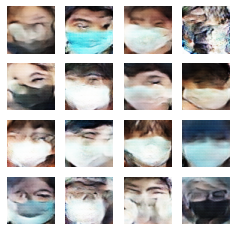

In [43]:
train(train_images,EPOCHS)